# <span style="color:teal"> Redes Neuronales Profundas </span>

## Evaluación parcial 1

### Clasificación de datos estructurados por medio de una red neuronal profunda

#### 1. Selección de la muestra
> * 1.1. En formato de datos estructurados (.csv)
> * 1.2. Pueden ser de algún tema de investigación propio o puede ser tomado de algún repositorio de datos (por ejemplo, Kaggle).
> * 1.3. Debe contener una cantidad mínima de datos (>500 entradas)
> * 1.4. Debe contener una cantidad mínima de variables (>5)
> * 1.5. El problema a resolver tiene que ser de clasificación (2 o más categorías)

### Predicción del éxito o fracaso de campañas de Kickstarter 

<img src="image.JPG" width="400"/>

En el marco de un curso previo se llevó a cabo un análisis de datos de un [dataset en Kaggle](https://www.kaggle.com/kemical/kickstarter-projects) acerca de campañas de kickstarter. Las campañas pueden ser exitosas o fracasar. El ejercicio actual se dedicará a encontrar un algoritmo que logre predecir si una campaña con ciertas características será exitosa o no.

Para comenzar importarmos librerías de utilidad general para el análisis de datos:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Leemos el archivo y vemos las primeras lineas:

In [2]:
df = pd.read_csv('ksprojects2018.csv')
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


Establecemos sus dimensiones y comprobamos que cumple con los requisitos de complejidad:

In [3]:
df.shape

(378661, 15)

El dataset cuenta con 378,661 filas y 15 columnas por lo que se comprueba que nos será de utilidad.

#### Descripción de las columnas:

In [4]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

* ID - Número de identificación de la campaña
* name - Nombre de la campaña
* category - Categoría específica a la que corresponde
* main_category - Categoría principal a la cual pertenece la categoría previa
* currency - Moneda en la cual se registró la campaña
* deadline - Fecha límite para aportaciones
* goal - Monto meta a recaudar 
* launched - Fecha de inicio
* pledged - Monto recaudado
* state - Estatus de la camapaña
* backers - Cantidad de personas que donaron a la campaña
* country - País de orígen
* usd pledged - Conversión a dólares por kickstarter del monto recaudado
* usd_pledged_real - Conversión real a dólares del monto recaudado
* usd_goal_real - Monto meta en dólares real

#### Detalles adicionales

Tipo de elementos en las columnas:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


Datos faltantes:

In [6]:
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

#### 2. Preprocesamiento de datos
> * 2.1. Eliminar columnas que no sean relevantes para el entrenamiento (columnas con un porcentaje de datos nulos > 30%, columnas que no son de utilidad para la red neuronal)
> * 2.2. En caso de que sea necesario a convertir a formato numérico hacer el respectivo mapeo, por ejemplo, en formato de fechas, o columnas que contengan caracteres y sea necesario convertirlo a clasificación (ejemplo “YES” -> 1 “NO”-> 0)
> * 2.3. Ya que los datos están listos para la red neuronal separar la muestra en un porcentaje para entrenamiento (75%) y validación (25%)
> * 2.4. Para un mejor desempeño de la red neuronal normalizar los valores de las columnas para un valor entre 0 y 1

Con base en la exploración inicial se pueden tomar algunas decisiones como:

* Eliminar la columna de usd pledged. Esta debería contener la misma información que usd_pledged_real pero con errores o diferencias en algunos casos, además de ser la columna con más datos faltantes, por lo que eliminarla deberá ser la mejor opción.

* Eliminar las columnas de goal y pledged. Estos datos será mejor manejarlos con base en las columnas en dólares para asegurar que los datos son homogéneos.

* Eliminar la columna de currency, este dato no es necesario.

* Con base en las columnas de launched y deadline obtener la duración de las campañas y crear una columna conteniendo esta información de manera que no sea necesario trabajar con fechas.

Antes de llevar a cabo estas acciones veamos la matríz de correlación correspondiente:

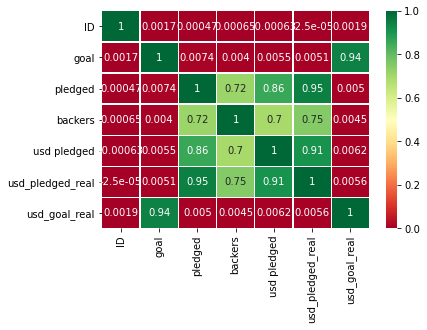

In [7]:
fig = sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)

Eliminamos las columnas seleccionadas:

In [8]:
cols = ['usd pledged', 'goal', 'pledged', 'currency']

df = df.drop(cols, axis=1)

In [9]:
df.head()

,ID,name,category,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00


#### Obtener la duración de las campañas

In [10]:
import datetime
import dfply

df['deadline'] = df['deadline'].astype('datetime64')
df['launched'] = df['launched'].astype('datetime64')

df = df >> dfply.mutate(duration = df.deadline - df.launched)

In [11]:
df.head()

,ID,name,category,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,58 days 11:47:32
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,59 days 19:16:03
2,1000004038,Where is Hank?,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,44 days 23:39:10
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,29 days 20:35:49
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00,55 days 15:24:57


De la nueva columna que obtuvimos nos quedaos unicamente con el número de días. A continuación se modifica con ayuda de la funcion split.

In [12]:
df['duration'] = df['duration'].astype('str')

df.duration = df.duration.str.split(expand=True)

df.duration = df.duration.astype('int')

df.duration

0         58
1         59
2         44
3         29
4         55
          ..
378656    29
378657    26
378658    45
378659    30
378660    27
Name: duration, Length: 378661, dtype: int32

En este punto, resulta útil hacer una exploración adicional de los datos, su distribución y características principales.

#### Detección de outliers

In [13]:
df.describe()

,ID,backers,usd_pledged_real,usd_goal_real,duration
count,3.786610e+05,378661.000000,3.786610e+05,3.786610e+05,378661.000000
mean,1.074731e+09,105.617476,9.058924e+03,4.545440e+04,33.481122
std,6.190862e+08,907.185035,9.097334e+04,1.152950e+06,65.909172
min,5.971000e+03,0.000000,0.000000e+00,1.000000e-02,0.000000
25%,5.382635e+08,2.000000,3.100000e+01,2.000000e+03,29.000000
50%,1.075276e+09,12.000000,6.243300e+02,5.500000e+03,29.000000
75%,1.610149e+09,56.000000,4.050000e+03,1.550000e+04,36.000000
max,2.147476e+09,219382.000000,2.033899e+07,1.663614e+08,16738.000000


En este resumen se pueden identificar algunos problemas con el dataset:

* Campañas con duración de cero días
* Campañas con duración de 16738 días

In [14]:
df.duration.unique()

array([   58,    59,    44,    29,    55,    34,    19,    27,    14,
          30,    39,    10,    24,    47,    40,    28,    41,    42,
          52,    33,    21,    16,    43,    45,    31,    65,    48,
          35,    60,    37,    36,    17,    32,    13,     4,    54,
          25,    50,    26,    18,    23,    51,    20,    15,    49,
          86,    22,    38,    12,    11,     9,    56,    82,     7,
          53,    89,     5,    46,    70,     8,    61,     0,     6,
          72,    57,    63,    90,     2,    88, 14866,    69,    68,
          71,     3,    67,    84,    66,    73,    80,    83,    87,
          74,     1,    64,    75,    62,    79,    78,    85,    77,
          81,    76,    91, 14834, 14749, 14760, 14732, 14708, 16738])

A excepción de unos pocos valores, la gran mayoría existen debajo de 100, así que veamos a detalle esos casos arriba de 100 días.

In [15]:
df >> dfply.mask(df.duration > 100)

,ID,name,category,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,duration
2842,1014746686,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,2010-09-15,1970-01-01 01:00:00,canceled,0,US,0.0,5000.00,14866
48147,1245461087,1st Super-Size Painting - Social Network Owned...,Art,Art,2010-08-14,1970-01-01 01:00:00,canceled,0,US,0.0,15000.00,14834
75397,1384087152,"""ICHOR"" (Canceled)",Film & Video,Film & Video,2010-05-21,1970-01-01 01:00:00,canceled,0,US,0.0,700.00,14749
94579,1480763647,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,Theater,2010-06-01,1970-01-01 01:00:00,canceled,0,US,0.0,4000.00,14760
247913,330942060,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,2010-05-04,1970-01-01 01:00:00,canceled,0,US,0.0,10000.00,14732
273779,462917959,Identity Communications Infographic (Canceled),Design,Design,2010-04-10,1970-01-01 01:00:00,canceled,0,US,0.0,500.00,14708
319002,69489148,Student Auditions Music 2015,Publishing,Publishing,2015-10-31,1970-01-01 01:00:00,suspended,0,CH,0.0,1905.97,16738


Aquí se confirma que estos valores son errores en el dataset ya que no pueden existir campañas del año 1970. Por lo que se procede a eliminar esas filas.

In [16]:
df = df >> dfply.mask(df.duration < 100)

df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,ID,backers,usd_pledged_real,usd_goal_real,duration
count,378654.00000,378654.00000,378654.00000,378654.00000,378654.00000
mean,1074735245.05727,105.61943,9059.09154,45455.14377,33.20342
std,619087167.35943,907.19331,90974.17566,1152960.69897,12.79317
min,5971.00000,0.00000,0.00000,0.01000,0.00000
25%,538269621.50000,2.00000,31.00000,2000.00000,29.00000
50%,1075275650.00000,12.00000,624.46500,5500.00000,29.00000
75%,1610155033.75000,56.00000,4050.00000,15500.00000,36.00000
max,2147476221.00000,219382.00000,20338986.27000,166361390.71000,91.00000


Ahora podemos eliminar las columnas de launched y deadline:

In [17]:
cols = ['launched', 'deadline']

df = df.drop(cols, axis=1)

df.head()

,ID,name,category,main_category,state,backers,country,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,failed,0,GB,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,failed,15,US,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,failed,3,US,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,failed,1,US,1.0,5000.00,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,canceled,14,US,1283.0,19500.00,55


Así tenemos un valor de duración máxima de 91 días para las camapañas. Sin embargo, un dato que puede ser también problemático son aquellas que tienen una duración de 0 días. A continuación analizamos un poco más a fondo esos casos.

In [18]:
no_duration = df >> dfply.mask(df.duration < 1) >> dfply.arrange('usd_pledged_real')
no_duration

,ID,name,category,main_category,state,backers,country,usd_pledged_real,usd_goal_real,duration
121499,1617139964,Get Patty's ass to the Burgh,Film & Video,Film & Video,failed,0,US,0.00,10000.00,0
103483,1526194584,A New Handbag,Accessories,Fashion,failed,0,US,0.00,1000.00,0
111819,156802730,Ideal Playing Cards Sticker Seals - Black & Go...,Playing Cards,Games,failed,0,US,0.00,1.00,0
118408,1601585086,Clock in the shape of an Apple,Design,Design,failed,0,US,0.00,1000.00,0
128829,165405157,A radio/TV station showcasing underground musi...,Hip-Hop,Music,failed,0,GB,0.00,23452.16,0
...,...,...,...,...,...,...,...,...,...,...
20368,1103482181,The Next Winged Queen (number 4!),Art,Art,failed,86,US,7670.00,8888.00,0
268704,43736794,Another Fucking Warhol Production,Performances,Dance,successful,161,US,7740.26,5000.00,0
83221,1423239824,Next Art Nouveau Winged Queen (Number 5!) by E...,Illustration,Art,failed,71,US,8385.00,8888.00,0
377311,993249553,1st Annual Brian Kesinger Christmas Ornament,Art,Art,successful,59,US,9244.00,1000.00,0


Para continuar el análisis se decide eliminar estos registros.

In [19]:
df = df >> dfply.mask(df.duration > 0)

Adicionalmente se inspeccionan los casos que no tuvieron patrocinadores.

In [20]:
no_backers = df >> dfply.mask(df.backers < 1)
no_backers.head()

,ID,name,category,main_category,state,backers,country,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,failed,0,GB,0.0,1533.95,58
10,100004721,Of Jesus and Madmen,Nonfiction,Publishing,failed,0,CA,0.0,2406.39,29
12,1000055792,The Cottage Market,Crafts,Crafts,failed,0,US,0.0,5000.00,29
13,1000056157,G-Spot Place for Gamers to connect with eachot...,Games,Games,failed,0,US,0.0,200000.00,44
26,1000103948,Superhero Teddy Bear,DIY,Crafts,failed,0,GB,0.0,17489.65,29


Se decide que los casos que no tuvieron patrocinadores no pueden identificarse como exitosos, por lo que se procede a eliminar esos 105 registros.

In [21]:
delete = no_backers >> dfply.mask(no_backers.state == 'successful')

delete = delete.index

df.drop(delete, inplace=True)

Existen campañas con una meta económica igual o menor a 10 dólares, estas introducen un grado de ruido en el dataset y se ha tomado la decisión de continuar el análisis sin considerarlas:

In [22]:
df >> dfply.mask(df.usd_goal_real < 11)

,ID,name,category,main_category,state,backers,country,usd_pledged_real,usd_goal_real,duration
363,1001685760,Wholesters- A new way to Whold your things!,Fashion,Fashion,successful,3,US,566.00,1.00,29
532,1002571103,3mm Aluminum Pick Plectrum,Music,Music,successful,9,CA,18.12,0.91,29
565,1002728217,Free soap from starting soap maker!,Crafts,Crafts,successful,16,US,36.00,10.00,29
764,100372771,A Big Dream of a Little Man - Alex Oddman's De...,Music,Music,canceled,1,US,7.00,1.00,29
993,1005030157,Tons Of Music For A Buck!!!,Rock,Music,successful,13,US,113.00,1.00,29
...,...,...,...,...,...,...,...,...,...,...
376800,990615883,Snap,Nature,Photography,failed,1,CA,0.90,9.00,29
377441,993961188,SWEET LITTLE BITTER by BAD REED,Rock,Music,successful,42,CA,1485.22,0.74,29
377757,995538414,Make a Tomato Pie !,Food,Food,successful,8,US,27.00,10.00,59
378342,998486147,Half Bloods Series,Drama,Film & Video,failed,0,US,0.00,1.00,30


In [23]:
df = df >> dfply.mask(df.usd_goal_real > 10)

Generamos una columna que nos ayude a establecer si la meta se alcanzó o no.

In [24]:
df['diff'] = df.usd_goal_real - df.usd_pledged_real

Si el campo de diferencia es menor que cero entonces las campañas han alcanzado e incluso superado la meta económica propuesta, por lo que estas debería tener como estado indicado el de éxito o un estado distinto al fracaso. A continuación nos aseguramos de esto:

In [25]:
goal_passed = df >> dfply.mask(df['diff'] < 0)

goal_passed.state.value_counts()

successful    129129
undefined       1582
canceled         592
live             423
suspended        266
failed             4
Name: state, dtype: int64

In [26]:
goal_passed >> dfply.mask(goal_passed.state == 'failed')

,ID,name,category,main_category,state,backers,country,usd_pledged_real,usd_goal_real,duration,diff
16780,1085047405,"""Balance""",Jazz,Music,failed,141,US,23020.01,23000.0,29,-20.01
58558,1297794474,Music Empowers - A Day with the Accende Ensemble,Classical Music,Music,failed,20,US,3087.50,3000.0,57,-87.50
216545,2103203254,The new face of Canadian Science Fiction,Fiction,Publishing,failed,66,US,10797.00,10000.0,58,-797.00
298960,59246799,Key Wrench - Unlock Your Life!,Product Design,Design,failed,208,US,6183.00,6000.0,40,-183.00


Se decide que estos registros introducen posible error en los datos y se eliminan.

In [27]:
delete1 = goal_passed >> dfply.mask(goal_passed.state == 'failed')
delete1 = delete1.index
df.drop(delete1, inplace=True)

In [28]:
df.describe()

,ID,backers,usd_pledged_real,usd_goal_real,duration,diff
count,3.773020e+05,377302.000000,3.773020e+05,3.773020e+05,377302.000000,3.773020e+05
mean,1.074897e+09,105.873128,9.079265e+03,4.532180e+04,33.225217,3.624254e+04
std,6.191135e+08,908.655512,9.102430e+04,1.143386e+06,12.777076,1.146489e+06
min,5.971000e+03,0.000000,0.000000e+00,1.022000e+01,1.000000,-1.983899e+07
25%,5.383288e+08,2.000000,3.100000e+01,2.000000e+03,29.000000,-2.000000e+02
50%,1.075655e+09,12.000000,6.290000e+02,5.500000e+03,29.000000,1.990000e+03
75%,1.610355e+09,56.000000,4.063000e+03,1.566795e+04,36.000000,1.000000e+04
max,2.147476e+09,219382.000000,2.033899e+07,1.663614e+08,91.000000,1.663614e+08


In [29]:
df.head()

,ID,name,category,main_category,state,backers,country,usd_pledged_real,usd_goal_real,duration,diff
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,failed,0,GB,0.0,1533.95,58,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,failed,15,US,2421.0,30000.00,59,27579.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,failed,3,US,220.0,45000.00,44,44780.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,failed,1,US,1.0,5000.00,29,4999.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,canceled,14,US,1283.0,19500.00,55,18217.00


In [30]:
df['name_length'] = df['name'].str.len()

In [31]:
cols = ['ID', 'name', 'diff']

df = df.drop(cols, axis=1)

df.head()

,category,main_category,state,backers,country,usd_pledged_real,usd_goal_real,duration,name_length
0,Poetry,Publishing,failed,0,GB,0.0,1533.95,58,31.0
1,Narrative Film,Film & Video,failed,15,US,2421.0,30000.00,59,45.0
2,Narrative Film,Film & Video,failed,3,US,220.0,45000.00,44,14.0
3,Music,Music,failed,1,US,1.0,5000.00,29,49.0
4,Film & Video,Film & Video,canceled,14,US,1283.0,19500.00,55,58.0


Veamos cuales son las categorías en las cuales pueden caer las campañas:

In [32]:
df.state.value_counts()

failed        197423
successful    133110
canceled       38617
undefined       3562
live            2791
suspended       1799
Name: state, dtype: int64

Trabajaremos unicamente con las campañas que fueron éxitosas y aquellas que fracasaron.

In [33]:
df = df.loc[df['state'].isin(['successful', 'failed'])]

In [34]:
df.country.unique()

array(['GB', 'US', 'CA', 'AU', 'NO', 'IT', 'DE', 'IE', 'MX', 'ES', 'SE',
       'FR', 'NZ', 'CH', 'AT', 'BE', 'DK', 'HK', 'NL', 'LU', 'SG', 'N,0"',
       'JP'], dtype=object)

In [35]:
df >> dfply.mask(df.country == 'N,0"')

,category,main_category,state,backers,country,usd_pledged_real,usd_goal_real,duration,name_length
10086,Film & Video,Film & Video,failed,0,"N,0""",0.00,8659.38,13,60.0
10527,Music,Music,failed,0,"N,0""",2768.20,4578.06,34,48.0
11191,Music,Music,failed,0,"N,0""",1.00,1500.00,4,23.0
14385,Publishing,Publishing,failed,0,"N,0""",618.00,4500.00,29,35.0
17525,Music,Music,failed,0,"N,0""",0.00,5000.00,29,22.0
...,...,...,...,...,...,...,...,...,...
356090,Music,Music,failed,0,"N,0""",1.46,1096.09,59,16.0
363806,Film & Video,Film & Video,failed,0,"N,0""",16.73,1673.10,29,54.0
368889,Music,Music,failed,0,"N,0""",1408.00,7500.00,29,41.0
371387,Print,Journalism,failed,0,"N,0""",2204.21,17104.54,29,21.0


In [36]:
delete = df >> dfply.mask(df.country == 'N,0"')

delete = delete.index

df.drop(delete, inplace=True)

In [37]:
df.head()

,category,main_category,state,backers,country,usd_pledged_real,usd_goal_real,duration,name_length
0,Poetry,Publishing,failed,0,GB,0.0,1533.95,58,31.0
1,Narrative Film,Film & Video,failed,15,US,2421.0,30000.00,59,45.0
2,Narrative Film,Film & Video,failed,3,US,220.0,45000.00,44,14.0
3,Music,Music,failed,1,US,1.0,5000.00,29,49.0
5,Restaurants,Food,successful,224,US,52375.0,50000.00,34,20.0


#### Dataset final

In [38]:
df = df[['main_category', 'category', 'country', 'name_length','duration', 'backers', 'usd_goal_real', 'usd_pledged_real', 'state']]
df.head()

,main_category,category,country,name_length,duration,backers,usd_goal_real,usd_pledged_real,state
0,Publishing,Poetry,GB,31.0,58,0,1533.95,0.0,failed
1,Film & Video,Narrative Film,US,45.0,59,15,30000.00,2421.0,failed
2,Film & Video,Narrative Film,US,14.0,44,3,45000.00,220.0,failed
3,Music,Music,US,49.0,29,1,5000.00,1.0,failed
5,Food,Restaurants,US,20.0,34,224,50000.00,52375.0,successful


In [39]:
df.shape

(330428, 9)

### Visualización de los datos

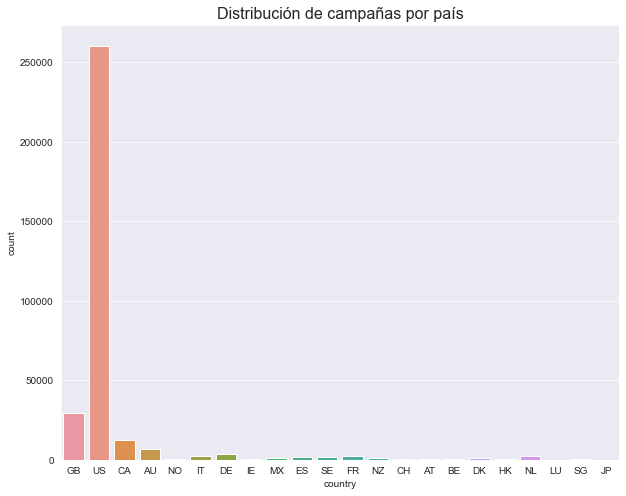

In [40]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,8))
sns.countplot(x='country', data=df)
plt.title('Distribución de campañas por país', fontsize=16)
plt.show()

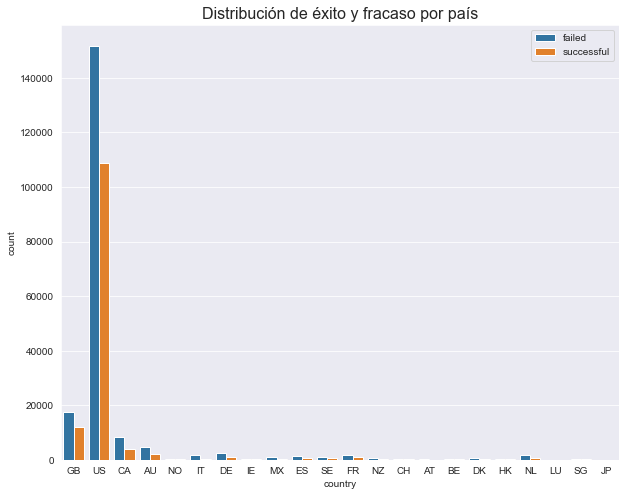

In [41]:
plt.figure(figsize=(10,8))
sns.countplot(x='country', data=df, hue = 'state')
plt.title('Distribución de éxito y fracaso por país', fontsize=16)
plt.legend(loc = 'upper right')
plt.show()

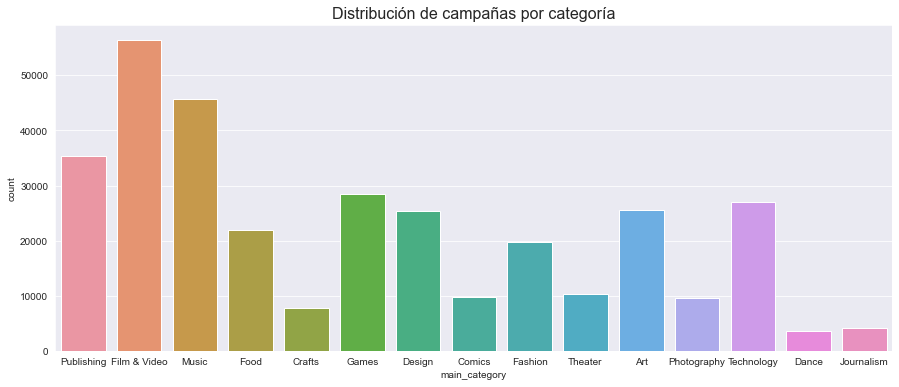

In [42]:
plt.figure(figsize=(15,6))
sns.countplot(x='main_category', data=df)
plt.title('Distribución de campañas por categoría', fontsize=16)
plt.show()

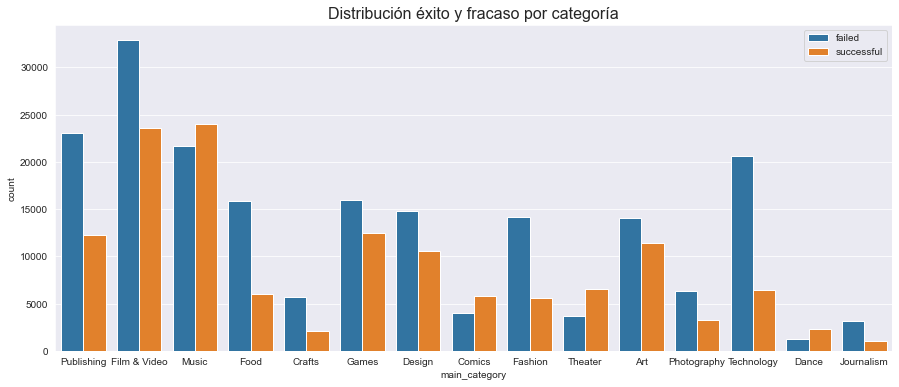

In [43]:
plt.figure(figsize=(15,6))
sns.countplot(x='main_category', data=df, hue = 'state')
plt.title('Distribución éxito y fracaso por categoría', fontsize=16)
plt.legend(loc = 'upper right')
plt.show()

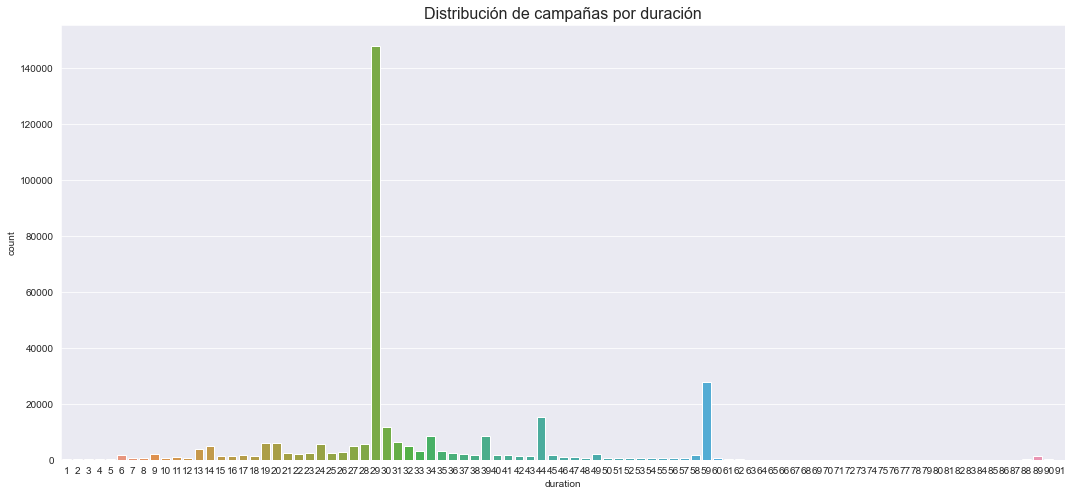

In [44]:
plt.figure(figsize=(18,8))
sns.countplot(x='duration', data=df)
plt.title('Distribución de campañas por duración', fontsize=16)
plt.show()

### Codificación de características

Existen columnas de tipo categórico que arrojan cierta información que puede ser útil al predecir el éxito o fracaso de las campañas, para poder trabajar con ellas es necesario realizar una codificación para poder utilizarlas como valores numéricos.

#### Éxito y fracaso

In [45]:
df.state.replace(['successful', 'failed'], [1, 0], inplace=True)

#### Otras

In [46]:
df.main_category.nunique()

15

In [47]:
df.main_category.unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Crafts', 'Games',
       'Design', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [48]:
df["main_category"] = df["main_category"].astype('category')
df["main_category"] = df["main_category"].cat.codes

In [49]:
df.category.nunique()

159

In [50]:
df.category.unique()

array(['Poetry', 'Narrative Film', 'Music', 'Restaurants', 'Food',
       'Drinks', 'Nonfiction', 'Indie Rock', 'Crafts', 'Games',
       'Tabletop Games', 'Design', 'Comic Books', 'Art Books', 'Fashion',
       'Childrenswear', 'Theater', 'Comics', 'DIY', 'Webseries',
       'Animation', 'Food Trucks', 'Product Design', 'Public Art',
       'Documentary', 'Illustration', 'Photography', 'Pop', 'People',
       'Art', 'Family', 'Fiction', 'Film & Video', 'Accessories', 'Rock',
       'Hardware', 'Software', 'Weaving', 'Web', 'Jazz', 'Ready-to-wear',
       'Festivals', 'Video Games', 'Anthologies', 'Publishing', 'Shorts',
       'Gadgets', 'Electronic Music', 'Radio & Podcasts', 'Cookbooks',
       'Apparel', 'Metal', 'Comedy', 'Hip-Hop', 'Periodicals', 'Dance',
       'Technology', 'Painting', 'World Music', 'Photobooks', 'Drama',
       'Architecture', 'Young Adult', 'Latin', 'Mobile Games', 'Flight',
       'Fine Art', 'Action', 'Playing Cards', 'Makerspaces', 'Punk',
       "Childre

In [51]:
df["category"] = df["category"].astype('category')
df["category"] = df["category"].cat.codes

In [52]:
df.country.nunique()

22

In [53]:
df.country.unique()

array(['GB', 'US', 'CA', 'AU', 'NO', 'IT', 'DE', 'IE', 'MX', 'ES', 'SE',
       'FR', 'NZ', 'CH', 'AT', 'BE', 'DK', 'HK', 'NL', 'LU', 'SG', 'JP'],
      dtype=object)

In [54]:
df["country"] = df["country"].astype('category')
df["country"] = df["country"].cat.codes

### Dataset con variables numéricas

In [55]:
df.head()

,main_category,category,country,name_length,duration,backers,usd_goal_real,usd_pledged_real,state
0,12,108,9,31.0,58,0,1533.95,0.0,0
1,6,93,21,45.0,59,15,30000.00,2421.0,0
2,6,93,21,14.0,44,3,45000.00,220.0,0
3,10,90,21,49.0,29,1,5000.00,1.0,0
5,7,123,21,20.0,34,224,50000.00,52375.0,1


In [56]:
df = df.dropna()

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330425 entries, 0 to 378660
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   main_category     330425 non-null  int8   
 1   category          330425 non-null  int16  
 2   country           330425 non-null  int8   
 3   name_length       330425 non-null  float64
 4   duration          330425 non-null  int32  
 5   backers           330425 non-null  int64  
 6   usd_goal_real     330425 non-null  float64
 7   usd_pledged_real  330425 non-null  float64
 8   state             330425 non-null  int64  
dtypes: float64(3), int16(1), int32(1), int64(2), int8(2)
memory usage: 17.6 MB


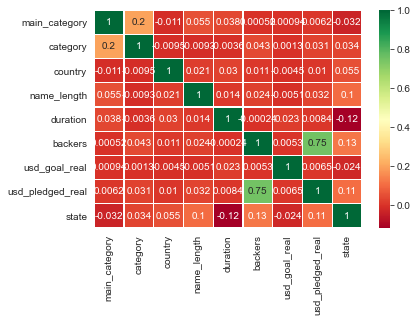

In [58]:
fig = sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)

### Escalar, excluyendo las variables categóricas

In [59]:
from sklearn.preprocessing import RobustScaler

cat_df = df[["main_category", "category", "country", "name_length"]]

y = df["state"]
X = df.drop(["state","main_category", "category", "country", "name_length"], axis = 1)
cols = X.columns
index = X.index

transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

X = pd.concat([X,cat_df], axis = 1)

X.head()


,duration,backers,usd_goal_real,usd_pledged_real,main_category,category,country,name_length
0,4.833333,-0.245902,-0.266619,-0.173609,12,108,9,31.0
1,5.000000,0.000000,1.923077,0.354416,6,93,21,45.0
2,2.500000,-0.196721,3.076923,-0.125627,6,93,21,14.0
3,0.000000,-0.229508,0.000000,-0.173391,10,90,21,49.0
5,0.833333,3.426230,3.461538,11.249485,7,123,21,20.0


In [60]:
y.head()

0    0
1    0
2    0
3    0
5    1
Name: state, dtype: int64

In [61]:
print(X.shape, y.shape)

(330425, 8) (330425,)


### Separación de entrenamiento y prueba

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

y_train = np.asarray(y_train, dtype = np.int)
y_test = np.asarray(y_test, dtype = np.int)

y_train = np.reshape(y_train, [y_train.shape[0],1])
y_test = np.reshape(y_test, [y_test.shape[0],1])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(247818, 8) (82607, 8) (247818, 1) (82607, 1)


In [63]:
X_train.head()

,duration,backers,usd_goal_real,usd_pledged_real,main_category,category,country,name_length
217024,0.5,-0.245902,0.538462,-0.173609,13,8,21,11.0
5981,0.0,-0.049180,0.138462,-0.163577,1,25,21,10.0
171495,0.0,3.426230,1.769778,13.537722,4,37,17,44.0
170239,2.5,-0.081967,-0.326923,-0.138277,4,113,21,16.0
304224,0.0,0.213115,1.153846,1.260630,5,76,21,55.0


In [64]:
X_test.head()

,duration,backers,usd_goal_real,usd_pledged_real,main_category,category,country,name_length
111756,0.500000,0.016393,-0.307692,0.056488,5,52,21,55.0
122461,5.000000,0.311475,0.000000,0.052399,0,87,21,60.0
347156,5.000000,-0.131148,-0.187568,-0.140619,4,113,10,54.0
155692,2.500000,0.442623,-0.307692,0.058451,0,10,21,75.0
49315,3.166667,-0.180328,0.230769,-0.148309,10,68,21,39.0


#### 3. Definición de la red neuronal e hiperparametros
> * 3.1. Definir la configuración inicial de la red neuronal (como recomendación empezar con una configuración básica e ir cambiando dependiendo del desempeño)
> * 3.2. Seleccionar claramente los hiperparametros (factor de aprendizaje, funciones de activación, función de error, etc....)

In [65]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import Dropout

# Hiperparametros
training_epochs = 100
learning_rate = 0.01
momentum = 0.9

# Definicion del modelo
def create_model():
    model = tf.keras.Sequential()
    
    # Capa oculta
    model.add(tf.keras.layers.Dense(10, input_dim=8, activation='relu'))

    # Capa de salida
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilar el modelo   
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

#### 4. Entrenamiento de la red neuronal
> * 4.1. Realizar el entrenamiento de la red neuronal con keras
> * 4.2. Dependiendo de los resultados ajustar los hiperparametros para optimizar la red neuronal
> * 4.3. En caso de observar co-adaptacion de la red neuronal (overfitting) realizar un proceso de dropout
> * 4.4. Guardar el modelo (formato .h5)

In [66]:
model = create_model()
model.summary()

results = model.fit(
    X_train, y_train,
    epochs= training_epochs,
    batch_size=100,
    validation_data = (X_test, y_test),
    verbose = 1
)

print("Evaluating on training set...")
(loss, accuracy) = model.evaluate(X_train, y_train, verbose=0)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

print("Evaluating on testing set...")
(loss, accuracy) = model.evaluate(X_test, y_test, verbose=0)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2479/2479 [==============================] - 6s 2ms/step - loss: 3.0918 - accuracy: 0.7161 - val_loss: 0.2803 - val_accuracy: 0.9117
Epoch 2/100
2479/2479 [==============================] - 3s 1ms/step - loss: 0.2610 - accuracy: 0.9204 - val_loss: 0.2118 - val_accuracy: 0.9170
Epoch 3/100
2479/2479 [==============================] - 3s 1ms/step - loss: 0.1929 - accuracy: 0.9540 - val_loss: 0.1529 - val_accuracy: 0.9720
Epoch 4/100
2479/2479 [==============================] - 3s 1ms/step - loss: 0.1440 -

Epoch 53/100
2479/2479 [==============================] - 3s 1ms/step - loss: 0.0163 - accuracy: 0.9942 - val_loss: 0.0242 - val_accuracy: 0.9893
Epoch 54/100
2479/2479 [==============================] - 3s 1ms/step - loss: 0.0163 - accuracy: 0.9938 - val_loss: 0.0215 - val_accuracy: 0.9905
Epoch 55/100
2479/2479 [==============================] - 4s 1ms/step - loss: 0.0161 - accuracy: 0.9940 - val_loss: 0.0181 - val_accuracy: 0.9924
Epoch 56/100
2479/2479 [==============================] - 4s 1ms/step - loss: 0.0152 - accuracy: 0.9945 - val_loss: 0.0181 - val_accuracy: 0.9926
Epoch 57/100
2479/2479 [==============================] - 4s 2ms/step - loss: 0.0152 - accuracy: 0.9947 - val_loss: 0.0207 - val_accuracy: 0.9914
Epoch 58/100
2479/2479 [==============================] - 4s 2ms/step - loss: 0.0151 - accuracy: 0.9946 - val_loss: 0.0216 - val_accuracy: 0.9909
Epoch 59/100
2479/2479 [==============================] - 4s 2ms/step - loss: 0.0153 - accuracy: 0.9943 - val_loss: 0.0117 -

In [67]:
# Almacenamiento en formato h5

model.save("kickstarter.h5")

#### 5. Análisis de resultados y presentación
> * 5.1. Presentar los graficos finales de aprendizaje (error vs iteraciones, accuracy vs iteraciones)
> * 5.2. Presentar los resultados en forma vistosa y facil de interpretar para el lector (libreta jupyter formateada con imágenes y texto descriptivo, o algun medio para presentación de trabajo tipo blog como medium) recordar que gran parte de un trabajo es saber presentarlo y defenderlo

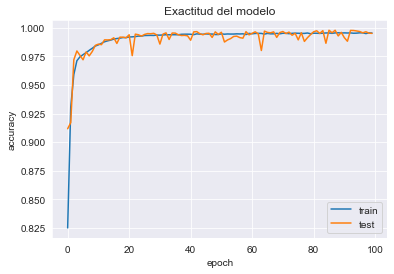

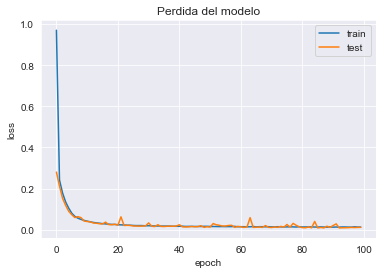

Maximum Loss : 0.9702

Minimum Loss : 0.0125

Loss difference : 0.9577


In [68]:
# Graficamos la exactitud
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Graficamos la perdida
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Perdida del modelo')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

max_loss = np.max(results.history['loss'])
min_loss = np.min(results.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("")
print("Minimum Loss : {:.4f}".format(min_loss))
print("")
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

#### 6. Conclusiones
> * 6.1. Interpretar los resultados de la red neuronal
> * 6.2. Discutir de qué manera podría ser implementado en una aplicación
> * 6.3. Discutir cuales serían las limitaciones de la red neuronal y de los resultados obtenidos